In [214]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Data explore

In [8]:
raw_data = pd.read_csv("adult.data", names = ["age", "workclass", "fnlwgt", "education", "education-num", 
                                              "marital-status", "occupation", "relationship", "race", "sex", 
                                              "capital-gain", "capital-loss", "hours-per-week", "native-country", "predict"])

In [9]:
raw_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predict
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [21]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
predict           32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [50]:
# map age to age_range
def cla(n,lim):
    return'[%.f,%.f)'%(lim*(n//lim),lim*(n//lim)+lim)

In [26]:
age_range = pd.Series([cla(age,10) for age in raw_data.age])
raw_data["age_range"] = age_range

In [49]:
raw_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predict,age_range
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,"[30,40)"
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,"[50,60)"
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,"[30,40)"
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,"[50,60)"
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,"[20,30)"


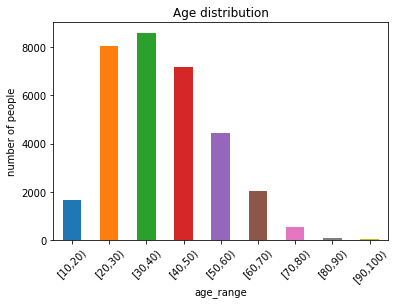

In [212]:
groups = raw_data.groupby(["age_range"]).count()
axes = groups["age"].plot(kind = "bar", rot = 45)
axes.set_ylabel("number of people")
axes.set_title("Age distribution")
plt.show()

This bar plot show the distribution of age in the dataset. I group the data by age range.The channel in this plot is color, position and length. Because we have one categorical value attribute and one quantitative value attributes, the bar plot can express the categorical values with horizontal position and express the quantitative value with the length of a bar. The task of this plot is to find the distribution of data.

This plot shows a chi-square distribution. Most of the people are in range [20, 60]. After plotting this bar chart, I think that use the age_range instead of age might be a good idea.

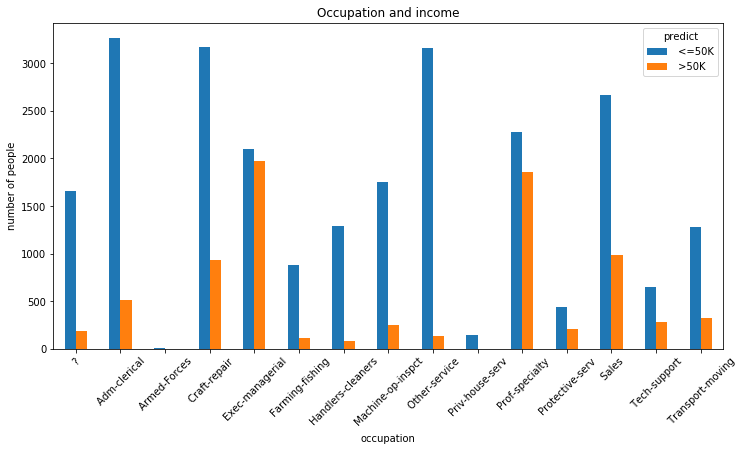

In [68]:
groups = raw_data.groupby(["occupation", "predict"]).count()
axes = groups["age"].unstack().plot(kind = "bar", figsize = (12, 6), rot = 45)
axes.set_ylabel("number of people")
axes.set_title("Occupation and income")
plt.show()

I use a bar plot to visualize the relationship between occupation and income. The data was grouped by occupation and income. The channel of this plot are color,position and length. Since this plot have two keys, the bars were grouped side-by-side.

I learn that the missing values are represented by " ?" and occupation did affect the income. The Exec-managerial and Prof-specialty are top two types of occupation that have large number of people that income over 50K. The Machine-op-inspct and Adm-clerical are top two types of occuption that most of the people income are low than 50K. This visualization shows that occupation is higly related to the income.

## Preprocessing

From the visualization, I noticed that the missing values were represented by " ?" in the data set, so I use the "Unknown" to replace them. Then I use one hot encoding for all the categorical features on the entire data set. Because if I split the data into train and test set first, there may be some categories that only exist in the test data set that can lead to an error when transforming the data. Then I split the data into train and test set, and apply standardization to the continuous features. Also I use age_range instead of age.

In [88]:
# fill na
raw_data.replace(" ?", "Unknown", inplace = True)

In [81]:
continuous = raw_data.loc[:, ["fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]]
categorical = raw_data.loc[:, ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "age_range"]]
y = raw_data.loc[:, "predict"]

In [132]:
# One hot encoding for categorical data
class_le = LabelEncoder()
for name in categorical.columns:
    categorical.loc[:, name] = class_le.fit_transform(categorical.loc[:, name])
one_hot_encoder = OneHotEncoder()
processed_cat = one_hot_encoder.fit_transform(categorical).toarray()

In [139]:
X = np.hstack((continuous.values, processed_cat))

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [166]:
# Standardization
scaler = StandardScaler().fit(X_train[:, 0:5])
X_train[:, 0:5]=scaler.transform(X_train[:, 0:5])
X_test[:, 0:5] = scaler.transform(X_test[:, 0:5])

## Modeling

In [179]:
%%time
k_range = range(1,11)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, p = 1, n_jobs = 8)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = "accuracy")
    k_scores.append(scores)
    knn = KNeighborsClassifier(n_neighbors = k, p = 2, n_jobs = 8)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = "accuracy")
    k_scores.append(scores)
    print(k)

1
2
3
4
5
6
7
8
9
10
Wall time: 13min 8s


In [189]:
l1_k_scores = pd.DataFrame()
l2_k_scores = pd.DataFrame()
for i in range(0,20):
    if(i%2 == 0):
        l1_k_scores["K=%d" % ((i+2)/2)] = k_scores[i]
    else:
        l2_k_scores["K=%d" % ((i+2)/2)] = k_scores[i]

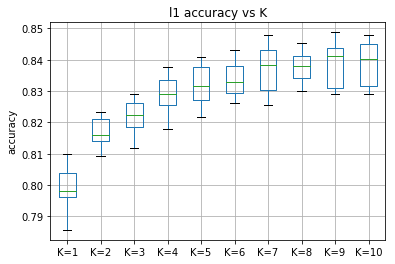

In [194]:
axes = l1_k_scores.boxplot()
axes.set_ylabel("accuracy")
axes.set_title("l1 accuracy vs K")
plt.show()

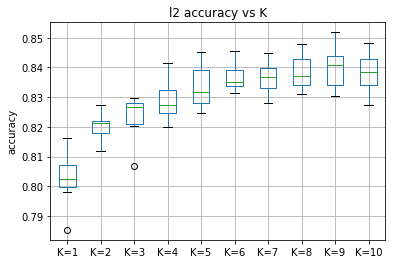

In [195]:
axes = l2_k_scores.boxplot()
axes.set_ylabel("accuracy")
axes.set_title("l2 accuracy vs K")
plt.show()

I use the boxplot to show all the result of 10-fold cv. The data have one categorical value attribute and one quantitative value attribute. This plot encode the categorical values with horizontal positions and express the distribution of quantitative values of each category and the trends of the data. The task is to find the best K and p. I choose K=6 as the best K and l2 as the best p. Because K=6 is the elbow point of the plot. Also compare two plots, l2 distance is slightly better than l1 distance given the same K.So I think K=6 and p=l2 are the best hyperparameters for this dataset.

In [206]:
knn = KNeighborsClassifier(n_neighbors = 6, p = 2, n_jobs = 8)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=8, n_neighbors=6, p=2,
           weights='uniform')

In [207]:
probility = knn.predict(X_test)
score = knn.score(X_test, y_test)

In [209]:
print("Accuracy: ", score)

Accuracy:  0.8320282511899278
